In [42]:
import igraph as ig
import leidenalg as la
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

In [43]:
# Função para carregar o dataset e filtrar pelo ano
def carregar_dados_deputados(caminho_dataset, ano_desejado):
    # Carregar o dataset
    df = pd.read_csv(caminho_dataset)

    # Converter a coluna 'data' para o formato de data (se ainda não estiver)
    df['data'] = pd.to_datetime(df['data'])

    # Filtrar pelo ano desejado
    df_filtrado = df[df['data'].dt.year == ano_desejado]

    return df_filtrado

In [44]:
# Função para executar o algoritmo de Leiden com diferentes níveis de poda de arestas
def analisar_comunidades_e_modularidade(grafo, intervalos_poda):
    comunidades_detectadas = []
    modularidades = []

    # Para cada nível de poda
    for percentual_poda in intervalos_poda:
        # Clonar o grafo para evitar modificar o original
        grafo_podado = grafo.copy()

        # Obter o peso máximo das arestas
        pesos = np.array(grafo_podado.es["weight"])
        peso_maximo = np.max(pesos)

        # Definir o valor de corte com base no percentual de poda
        limite_poda = peso_maximo * (percentual_poda / 100.0)

        # Remover arestas com peso abaixo do limite de poda
        arestas_para_remover = [e.index for e in grafo_podado.es if e["weight"] < limite_poda]
        grafo_podado.delete_edges(arestas_para_remover)

        # Garantir que todos os nós tenham pelo menos uma aresta conectada
        for vertice in grafo_podado.vs:
            if grafo_podado.degree(vertice) == 0:  # Se o nó não tiver arestas conectadas
                # Identificar as arestas originais do nó
                arestas_originais = grafo.es.select(_source=vertice.index)
                if len(arestas_originais) > 0:
                    # Manter a conexão com a aresta de maior peso
                    maior_aresta = max(arestas_originais, key=lambda e: e["weight"])
                    grafo_podado.add_edge(maior_aresta.source, maior_aresta.target, weight=maior_aresta["weight"])

        # Executar o algoritmo de Leiden no grafo podado
        particao = la.find_partition(grafo_podado, la.ModularityVertexPartition, seed=42)

        # Salvar o número de comunidades detectadas e a modularidade
        comunidades_detectadas.append(len(particao))
        modularidades.append(particao.modularity)
    
    return comunidades_detectadas, modularidades

In [45]:
# Função para garantir que todas as comunidades tenham pelo menos uma conexão entre si
def garantir_conectividade_entre_comunidades(grafo, particao):
    # Obter o número de comunidades detectadas
    num_comunidades = max(particao.membership) + 1

    # Criar um grafo onde os nós são as comunidades
    grafo_comunidades = ig.Graph(n=num_comunidades, directed=False)

    # Adicionar arestas entre comunidades com base nas conexões dos nós
    for aresta in grafo.es:
        origem = particao.membership[aresta.source]
        destino = particao.membership[aresta.target]
        if origem != destino:
            grafo_comunidades.add_edge(origem, destino)

    # Verificar se o grafo das comunidades está conectado
    if not grafo_comunidades.is_connected():
        # Se não estiver conectado, identificar componentes desconectados
        componentes = grafo_comunidades.components()
        
        # Para cada par de componentes desconectados, reconectar com a aresta de maior peso
        for i in range(len(componentes) - 1):
            comunidade_origem = componentes[i][0]
            comunidade_destino = componentes[i + 1][0]

            # Encontrar as arestas que conectam essas duas comunidades no grafo original
            arestas_entre_comunidades = [
                aresta for aresta in grafo.es
                if (particao.membership[aresta.source] == comunidade_origem and particao.membership[aresta.target] == comunidade_destino) or
                   (particao.membership[aresta.source] == comunidade_destino and particao.membership[aresta.target] == comunidade_origem)
            ]

            if arestas_entre_comunidades:
                # Selecionar a aresta de maior peso para reconectar
                maior_aresta = max(arestas_entre_comunidades, key=lambda e: e["weight"])

                # Adicionar a aresta de volta ao grafo
                grafo.add_edge(maior_aresta.source, maior_aresta.target, weight=maior_aresta["weight"])

    return grafo

In [46]:
# Função para adicionar a orientação política ao grafo com base no partido
def adicionar_orientacao_politica(grafo, df_deputados):
    # Mapeamento dos partidos para suas orientações (exemplo)
    orientacao_partidos = {
        "PT": "esquerda",
        "PSOL": "esquerda",
        "PCdoB": "esquerda",
        "PL": "direita",
        "PP": "direita",
        "REPUBLICANOS": "centro-direita",
        "MDB": "centro",
        "PSB": "centro-esquerda",
        "PSD": "centro",
        "AGIR": "direita",
        "CIDADANIA": "centro-esquerda",
        "DC": "direita",
        "NOVO": "direita",
        "PCB": "esquerda",
        "PCO": "esquerda",
        "PDT": "centro-esquerda",
        "PMB": "direita",
        "PMN": "esquerda",
        "PODE": "centro-direita",
        "PRTB": "direita",
        "PSDB": "centro",
        "PV": "esquerda",
        "REDE": "esquerda",
        "SOLIDARIEDADE": "centro",
        "PSL": "centro-direita",
        "PR": "direita",
        "PTN": "direita",
        "AVANTE": "centro",
        "PMDB": "centro",
        "PRB": "direita",
        "PSC": "direita",
        "PTB": "direita",
        "PFL": "centro-direita",
        "DEM": "centro-direita",
        "UNIÃO": "centro-direita",
        "PPS": "esquerda",
        "PROS": "centro",
        "PATRIOTA": "direita"


        # Adicionar outros partidos conforme necessário
    }

    for vertice in grafo.vs:
        # Atribuir o partido do deputado
        partido = vertice["sigla_partido"]
        
        # Adicionar a orientação com base no partido
        vertice["orientacao"] = orientacao_partidos.get(partido, "desconhecido")  # Se partido não encontrado, colocar "desconhecido"

    return grafo

In [47]:
# Adicionar as informações de nome, partido e UF aos nós do grafo
def adicionar_informacoes_ao_grafo(grafo, df_deputados):
    # Assumindo que os IDs dos nós correspondem à ordem ou a um identificador do deputado,
    # aqui vamos iterar pelos nós e adicionar as informações relevantes.
    for vertice in grafo.vs:
        # Supondo que o atributo "nome_deputado" já exista no grafo (ou você pode usar outro identificador)
        # Garantir que o 'label' seja tratado como inteiro, mesmo que venha como string com decimal
        id_deputado_str = str(vertice["label"])  # Converter para string se não for
        id_deputado = int(id_deputado_str.split('.')[0])  # Remover a parte decimal e converter para int


        # Encontrar o deputado correspondente no dataset
        deputado_info = df_deputados[df_deputados["id_deputado"] == id_deputado]

        if not deputado_info.empty:
            # Adicionar as informações ao grafo
            vertice["nome"] = deputado_info["nome"].values[0]
            vertice["sigla_uf"] = deputado_info["sigla_uf"].values[0]
            vertice["sigla_partido"] = deputado_info["sigla_partido"].values[0]
        else:
            print(f"Deputado {id_deputado} não encontrado no dataset.")

    return grafo

In [48]:
# Função para podar o grafo e adicionar as informações
def podar_grafo_e_adicionar_info(grafo, percentual_poda, df_deputados):
    grafo_podado = grafo.copy()

    pesos = np.array(grafo_podado.es["weight"])
    peso_maximo = np.max(pesos)
    limite_poda = peso_maximo * (percentual_poda / 100.0)

    arestas_para_remover = [e.index for e in grafo_podado.es if e["weight"] < limite_poda]
    grafo_podado.delete_edges(arestas_para_remover)

    for vertice in grafo_podado.vs:
        if grafo_podado.degree(vertice) == 0:
            arestas_originais_saida = grafo.es.select(_source=vertice.index)
            arestas_originais_entrada = grafo.es.select(_target=vertice.index)

            arestas_originais = list(arestas_originais_saida) + list(arestas_originais_entrada)

            if len(arestas_originais) > 0:
                maior_aresta = max(arestas_originais, key=lambda e: e["weight"])
                grafo_podado.add_edge(maior_aresta.source, maior_aresta.target, weight=maior_aresta["weight"])

    particao = la.find_partition(grafo_podado, la.ModularityVertexPartition, seed=42)
    grafo_podado = garantir_conectividade_entre_comunidades(grafo_podado, particao)

    # Adicionar as informações de nome, partido e UF
    grafo_podado = adicionar_informacoes_ao_grafo(grafo_podado, df_deputados)

    return grafo_podado

In [49]:
# Função para adicionar a comunidade de cada nó como um atributo ao grafo
def adicionar_comunidades_ao_grafo(grafo, particao):
    # Adicionar o rótulo da comunidade a cada nó
    grafo.vs["comunidade"] = particao.membership

In [50]:
# Carregar o grafo a partir do arquivo .gml
grafo = ig.Graph.Read_GML("grafo_deputados_atualizado.gml")

In [51]:
# Definir os intervalos de poda (0%, 10%, ..., 100%)
intervalos_poda = list(range(0, 100, 2))

# Analisar as comunidades e modularidade para cada nível de poda
comunidades_detectadas, modularidades = analisar_comunidades_e_modularidade(grafo, intervalos_poda)

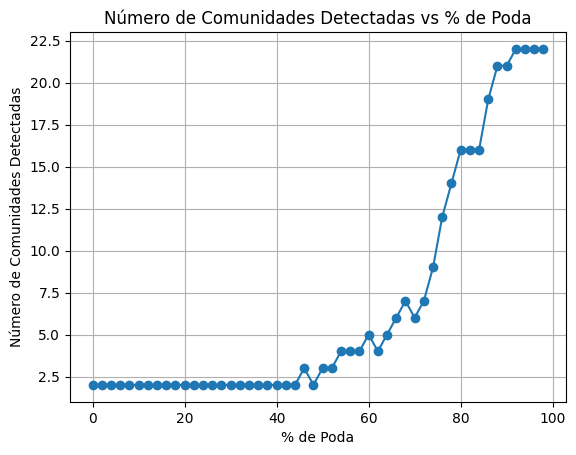

In [52]:
# Gráfico 1: Número de comunidades detectadas pelo % de poda
plt.figure()
plt.plot(intervalos_poda, comunidades_detectadas, marker='o')
plt.title("Número de Comunidades Detectadas vs % de Poda")
plt.xlabel("% de Poda")
plt.ylabel("Número de Comunidades Detectadas")
plt.grid(True)
plt.show()

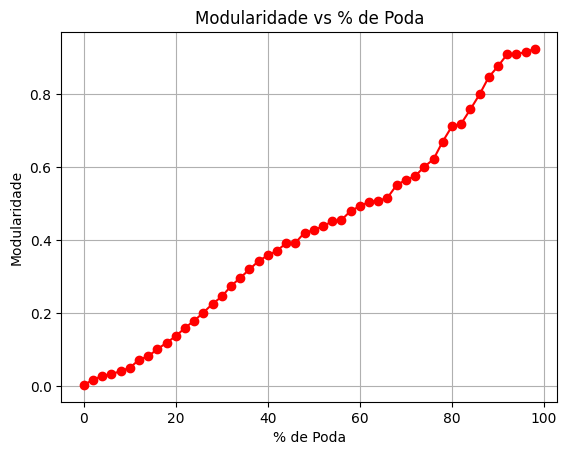

In [53]:
# Gráfico 2: Modularidade pelo % de poda
plt.figure()
plt.plot(intervalos_poda, modularidades, marker='o', color='red')
plt.title("Modularidade vs % de Poda")
plt.xlabel("% de Poda")
plt.ylabel("Modularidade")
plt.grid(True)
plt.show()

In [54]:
# Encontrar os picos (máximos locais) usando scipy
peaks, _ = find_peaks(modularidades)

# Exibir os índices dos picos e os valores correspondentes
print(f"Índices dos picos: {peaks}")
print(f"Valores de modularidade nos picos: {[modularidades[i] for i in peaks]}")
print(f"% de poda nos picos: {[intervalos_poda[i] for i in peaks]}")

Índices dos picos: []
Valores de modularidade nos picos: []
% de poda nos picos: []


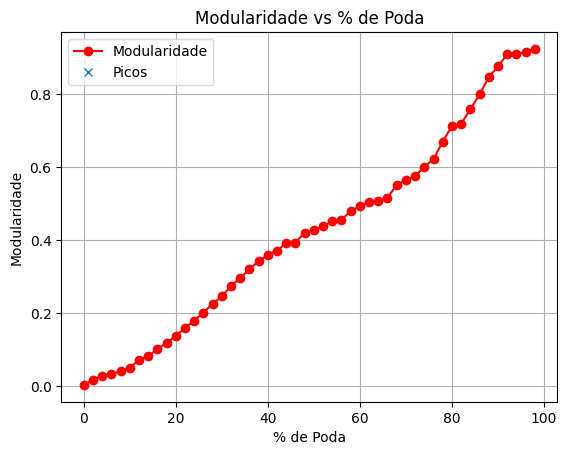

In [55]:
# Plotar o gráfico com os picos
plt.plot(intervalos_poda, modularidades, marker='o', color='red', label="Modularidade")
plt.plot(np.array(intervalos_poda)[peaks], np.array(modularidades)[peaks], "x", label="Picos")
plt.title("Modularidade vs % de Poda")
plt.xlabel("% de Poda")
plt.ylabel("Modularidade")
plt.grid(True)
plt.legend()
plt.show()

In [56]:
# Carregar o dataset de deputados
caminho_dataset = "../data/dados abertos/votacao_parlamentar.csv"
ano_desejado = 2022  # Especificar o ano que você deseja filtrar

# Carregar e filtrar o dataset
df_deputados_filtrado = carregar_dados_deputados(caminho_dataset, ano_desejado)

# Definir o % de poda no qual ocorre o pico (substitua pelo valor que você encontrou)
percentual_pico = 48  # Exemplo, substitua com o valor real

# Podar o grafo com o percentual correspondente ao máximo local
grafo_podado = podar_grafo_e_adicionar_info(grafo, percentual_pico, df_deputados_filtrado)

# Executar o algoritmo de Leiden no grafo podado para detectar comunidades
particao = la.find_partition(grafo_podado, la.ModularityVertexPartition, seed=42)

# Adicionar a comunidade como atributo do nó no grafo podado
adicionar_comunidades_ao_grafo(grafo_podado, particao)

# Adicionar a orientação política ao grafo
grafo_podado = adicionar_orientacao_politica(grafo_podado, df_deputados_filtrado)

# Exportar o grafo podado com as comunidades para um arquivo .gml
grafo_podado.write_gml(f"grafo_podado.gml")

print(f"Grafo podado com {percentual_pico}% e comunidades exportado para 'grafo_podado_{percentual_pico}_pico_comunidades.gml'")

Grafo podado com 48% e comunidades exportado para 'grafo_podado_48_pico_comunidades.gml'
